In [1]:
import struct
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf

from phdr.data.hoda_dataset_reader import read_hoda_cdb, read_hoda_dataset


2022-12-16 10:24:15.712826: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-16 10:24:15.868953: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
data_base_path = "../data/raw/hoda/"

print('Reading Train 60000.cdb ...')
train_images, train_labels = read_hoda_cdb(data_base_path + 'train_60k.cdb')

print('Reading Test 20000.cdb ...')
test_images, test_labels = read_hoda_cdb(data_base_path + 'test_20k.cdb')

print('Reading RemainingSamples.cdb ...')
remaining_images, remaining_labels = read_hoda_cdb(data_base_path + 'remaining_samples.cdb')


Reading Train 60000.cdb ...
Reading Test 20000.cdb ...
Reading RemainingSamples.cdb ...


In [3]:
print(test_labels[:5])
print(test_images[:1])


[0, 0, 0, 0, 0]
[array([[  0,   0,   0,   0,   0,   0, 255, 255,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
          0,   0,   0],
       [  0,   0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255,   0,   0],
       [  0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255,   0],
       [  0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255],
       [  0, 255, 255, 255, 255, 255,   0,   0,   0,   0, 255, 255, 255,
        255, 255, 255],
       [255, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0, 255, 255,
        255, 255, 255],
       [255, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0, 255, 255,
        255, 255, 255],
       [255, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0, 255, 255,
        255, 255, 255],
       [255, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0, 255, 255,
        255, 255,   0],
       [  0, 

In [4]:
print(len(train_images))
print(len(test_images))


60000
20000


In [5]:
data_ratio = 0.1
train_images = train_images[:int(len(train_images) * data_ratio)]
train_labels = train_labels[:int(len(train_labels) * data_ratio)]
test_images = test_images[:int(len(test_images) * data_ratio)]
test_labels = test_labels[:int(len(test_labels) * data_ratio)]

print(len(train_images))
print(len(test_images))


6000
2000


In [6]:
x_train = np.squeeze(train_images)
y_train = np.squeeze(train_labels)
x_test = np.squeeze(test_images)
y_test = np.squeeze(test_labels)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(6000,)
(6000,)
(2000,)
(2000,)


/home/smbh/.virtualenvs/phdr/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


label:  0


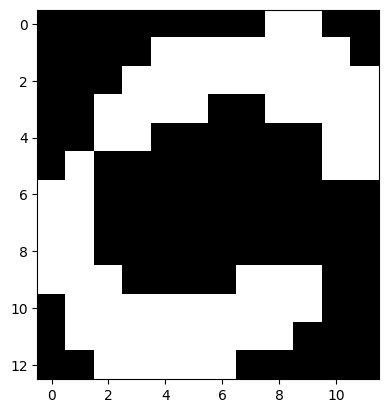

In [7]:
print("label: ", y_test[10])
plt.imshow(x_test[10], cmap="gray")
plt.show()


In [8]:
# resize 5 by 5 (to reduce features)
x_train_5x5 = [resize(img, (5, 5)) for img in x_train]
x_test_5x5 = [resize(img, (5, 5)) for img in x_test]


label:  0


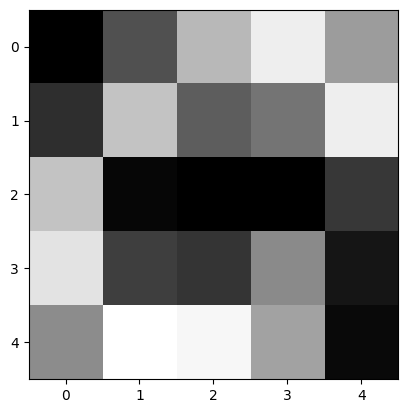

In [9]:
print("label: ", y_test[10])
plt.imshow(x_test_5x5[10], cmap="gray")
plt.show()


In [10]:
# reshape 5x5 to a vector with 25 items
x_train_5x5_feat = [x.reshape(25) for x in x_train_5x5]
x_test_5x5_feat = [x.reshape(25) for x in x_test_5x5]


In [13]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64, input_shape=(25,), activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                1664      
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 2,314
Trainable params: 2,314
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(
    np.array(x_train_5x5_feat),
    tf.keras.utils.to_categorical(y_train),
    epochs=30,
    batch_size=64
)


Epoch 1/30
94/94 [==============================] - 0s 765us/step - loss: 0.8075 - accuracy: 0.8553
Epoch 2/30
94/94 [==============================] - 0s 633us/step - loss: 0.5555 - accuracy: 0.8835
Epoch 3/30
94/94 [==============================] - 0s 641us/step - loss: 0.4270 - accuracy: 0.8972
Epoch 4/30
94/94 [==============================] - 0s 645us/step - loss: 0.3504 - accuracy: 0.9137
Epoch 5/30
94/94 [==============================] - 0s 632us/step - loss: 0.3012 - accuracy: 0.9198
Epoch 6/30
94/94 [==============================] - 0s 628us/step - loss: 0.2669 - accuracy: 0.9320
Epoch 7/30
94/94 [==============================] - 0s 635us/step - loss: 0.2434 - accuracy: 0.9367
Epoch 8/30
94/94 [==============================] - 0s 650us/step - loss: 0.2239 - accuracy: 0.9410
Epoch 9/30
94/94 [==============================] - 0s 659us/step - loss: 0.2094 - accuracy: 0.9438
Epoch 10/30
94/94 [==============================] - 0s 631us/step - loss: 0.1986 - accuracy: 0.9462

In [21]:
# evaluate the model
score = model.evaluate(np.array(x_test_5x5_feat), tf.keras.utils.to_categorical(y_test), verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


ValueError: in user code:

    File "/home/smbh/.virtualenvs/phdr/lib/python3.10/site-packages/keras/engine/training.py", line 1820, in test_function  *
        return step_function(self, iterator)
    File "/home/smbh/.virtualenvs/phdr/lib/python3.10/site-packages/keras/engine/training.py", line 1804, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/smbh/.virtualenvs/phdr/lib/python3.10/site-packages/keras/engine/training.py", line 1792, in run_step  **
        outputs = model.test_step(data)
    File "/home/smbh/.virtualenvs/phdr/lib/python3.10/site-packages/keras/engine/training.py", line 1758, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/smbh/.virtualenvs/phdr/lib/python3.10/site-packages/keras/engine/training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "/home/smbh/.virtualenvs/phdr/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/smbh/.virtualenvs/phdr/lib/python3.10/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/smbh/.virtualenvs/phdr/lib/python3.10/site-packages/keras/losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/smbh/.virtualenvs/phdr/lib/python3.10/site-packages/keras/losses.py", line 2004, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/home/smbh/.virtualenvs/phdr/lib/python3.10/site-packages/keras/backend.py", line 5532, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 10) are incompatible
